In [1]:
image_size = 224
batch_size = 16
epochs = 50
lr = 0.001

In [2]:
import time
import numpy
import tensorflow 
from tensorflow import keras
from keras import Sequential
from tensorflow.keras import backend as K
from keras.layers import Dense, Flatten, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras import regularizers, Model
from keras.applications.efficientnet import EfficientNetB3 , EfficientNetB7
from keras.applications import MobileNetV2, InceptionV3, DenseNet201, VGG16, Xception
from keras.optimizers import Adamax, Adam
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import MultiHeadAttention, Dense, Flatten, GlobalAveragePooling2D, Input, BatchNormalization, Dropout, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adamax

In [3]:
train_dataset = keras.utils.image_dataset_from_directory(
    directory = '/kaggle/input/plant26-hd/Data Aug New/Train',
    image_size=(image_size, image_size),
    batch_size=batch_size
)

validation_dataset = keras.utils.image_dataset_from_directory(
    directory = '/kaggle/input/plant26-hd/Data Aug New/Validation',
    image_size=(image_size, image_size),
    batch_size=batch_size
)

test_dataset = keras.utils.image_dataset_from_directory(
    directory = "/kaggle/input/plant26-hd/Data Aug New/Test",
    image_size=(image_size, image_size),
    batch_size=batch_size
)

Found 13000 files belonging to 26 classes.
Found 639 files belonging to 26 classes.
Found 1291 files belonging to 26 classes.


In [4]:
class_names = train_dataset.class_names
num_classes = len(class_names)

In [5]:
def process(image, label):
    image = tensorflow.cast(image/255. ,tensorflow.float32)
    return image, label

train_dataset = train_dataset.map(process)
validation_dataset = validation_dataset.map(process)
test_dataset = test_dataset.map(process)

In [6]:
base_model = EfficientNetB7(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))
base_model.trainable = True

inputs = Input(shape=(image_size, image_size, 3))
x = base_model(inputs)
x = GlobalAveragePooling2D()(x)
x = Lambda(lambda x: tensorflow.expand_dims(x, axis=1), output_shape=lambda s: (s[0], 1, s[1]))(x)
attention_output = MultiHeadAttention(num_heads=4, key_dim=512)(x, x)
x = Flatten()(attention_output)
x = BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001)(x)
x = Dense(256, 
          kernel_regularizer=regularizers.l2(0.01),
          activity_regularizer=regularizers.l1(0.001),
          bias_regularizer=regularizers.l1(0.006),
          activation='relu')(x)
x = Dropout(rate=0.2, seed=123)(x)
output = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=inputs, outputs=output)
model.compile(optimizer=Adamax(learning_rate=lr), 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

258076736/258076736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [7]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ efficientnetb7      │ (None, 7, 7,      │ 64,097,687 │ input_layer_1[0]… │
│ (Functional)        │ 2560)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 2560)      │          0 │ efficientnetb7[0… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 1, 2560)   │          0 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 1, 2560)   │ 20,980,224 │ lambda[0][0],     │
│ (MultiHeadAttentio… │                   │            │ lambda[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 2560)      │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 2560)      │     10,240 │ flatten[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │    655,616 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 256)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 26)        │      6,682 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 85,750,449 (327.11 MB)

 Trainable params: 85,434,602 (325.91 MB)

 Non-trainable params: 315,847 (1.20 MB)

In [8]:
history = model.fit(train_dataset, epochs=epochs, validation_data=validation_dataset)

Epoch 1/50


/opt/conda/lib/python3.10/site-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis 3 of a tensor of shape (None, 4, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(
I0000 00:00:1729428356.931133      99 service.cc:145] XLA service 0x7b3920007cf0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1729428356.931186      99 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1729428618.706156      99 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


812/813 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step - accuracy: 0.6801 - loss: 6.9216

I0000 00:00:1729429192.965169      98 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_2', 36 bytes spill stores, 36 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_4', 356 bytes spill stores, 356 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_7', 40 bytes spill stores, 40 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_11', 36 bytes spill stores, 36 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_13', 40 bytes spill stores, 40 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_14', 36 bytes spill stores, 36 bytes spill loads



813/813 ━━━━━━━━━━━━━━━━━━━━ 979s 742ms/step - accuracy: 0.6805 - loss: 6.9173 - val_accuracy: 0.9374 - val_loss: 3.3574
Epoch 2/50
813/813 ━━━━━━━━━━━━━━━━━━━━ 307s 378ms/step - accuracy: 0.9669 - loss: 2.8164 - val_accuracy: 0.9515 - val_loss: 1.6977
Epoch 3/50
813/813 ━━━━━━━━━━━━━━━━━━━━ 307s 377ms/step - accuracy: 0.9796 - loss: 1.3975 - val_accuracy: 0.9593 - val_loss: 0.9394
Epoch 4/50
813/813 ━━━━━━━━━━━━━━━━━━━━ 306s 377ms/step - accuracy: 0.9881 - loss: 0.7867 - val_accuracy: 0.9546 - val_loss: 0.7545
Epoch 5/50
813/813 ━━━━━━━━━━━━━━━━━━━━ 306s 376ms/step - accuracy: 0.9903 - loss: 0.5759 - val_accuracy: 0.9750 - val_loss: 0.5661
Epoch 6/50
813/813 ━━━━━━━━━━━━━━━━━━━━ 306s 376ms/step - accuracy: 0.9933 - loss: 0.4730 - val_accuracy: 0.9812 - val_loss: 0.4609
Epoch 7/50
813/813 ━━━━━━━━━━━━━━━━━━━━ 306s 376ms/step - accuracy: 0.9953 - loss: 0.4141 - val_accuracy: 0.9812 - val_loss: 0.4260
Epoch 8/50
813/813 ━━━━━━━━━━━━━━━━━━━━ 306s 376ms/step - accuracy: 0.9962 - loss: 0.37

In [9]:
def get_gflops(model):
    flops = 0
    input_shape = (1, 224, 224, 3)  

    for layer in model.layers:
        if isinstance(layer, tensorflow.keras.layers.Conv2D):
            input_channels = input_shape[-1]
            kernel_height, kernel_width = layer.kernel_size
            output_height = (input_shape[1] - kernel_height + 1) // layer.strides[0]  
            output_width = (input_shape[2] - kernel_width + 1) // layer.strides[1]  
            
            flops += layer.filters * (kernel_height * kernel_width * input_channels) * (output_height * output_width)
            input_shape = (1, output_height, output_width, layer.filters)  

        elif isinstance(layer, tensorflow.keras.layers.Dense):
            flops += layer.units * layer.input.shape[-1]

        elif isinstance(layer, tensorflow.keras.layers.BatchNormalization):
            flops += 2 * layer.input.shape[-1]  

    return flops / 1e9  

gflops = get_gflops(model)
print(f"Total GFLOPS: {gflops:.4f}")

Total GFLOPS: 0.0007


In [10]:
for test_images, test_labels in test_dataset.take(1):
    start_time = time.time()
    predictions = model.predict(test_images)
    end_time = time.time()

    prediction_time = end_time - start_time
    print(f"Prediction time for one image: {prediction_time:.4f} seconds")

/opt/conda/lib/python3.10/site-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis 3 of a tensor of shape (16, 4, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step
Prediction time for one image: 14.1108 seconds


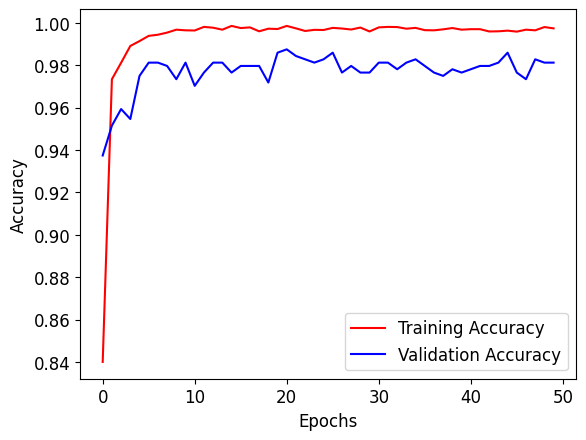

In [11]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 12})
plt.plot(history.history['accuracy'], color='red', label='Training Accuracy')
plt.plot(history.history['val_accuracy'], color='blue', label='Validation Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

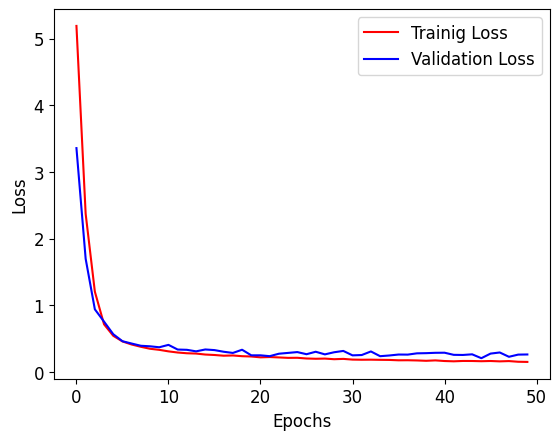

In [12]:
plt.rcParams.update({'font.size': 12})
plt.plot(history.history['loss'], color='red', label='Trainig Loss')
plt.plot(history.history['val_loss'], color='blue', label='Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [13]:
from sklearn.metrics import classification_report
import numpy as np

y_truev = []
y_predv = []
for images, labels in validation_dataset:
    preds = model.predict(images)
    preds = np.argmax(preds, axis=1)
    y_truev.extend(labels.numpy())
    y_predv.extend(preds)

report = classification_report(y_truev, y_predv, target_names=class_names, output_dict=True)

accuracyv = report['accuracy']
macro_avg_precisionv = report['macro avg']['precision']
macro_avg_recallv = report['macro avg']['recall']
macro_avg_f1v = report['macro avg']['f1-score']
weighted_avg_precisionv = report['weighted avg']['precision']
weighted_avg_recallv = report['weighted avg']['recall']
weighted_avg_f1v = report['weighted avg']['f1-score']

print(f"Results for Validation dataset")
print(f"---------------------------------")
print(f"Overall Accuracy: {accuracyv:.4f}")
print(f"Macro Average Precision: {macro_avg_precisionv:.4f}")
print(f"Macro Average Recall: {macro_avg_recallv:.4f}")
print(f"Macro Average F1-Score: {macro_avg_f1v:.4f}")
print(f"Weighted Average Precision: {weighted_avg_precisionv:.4f}")
print(f"Weighted Average Recall: {weighted_avg_recallv:.4f}")
print(f"Weighted Average F1-Score: {weighted_avg_f1v:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━

/opt/conda/lib/python3.10/site-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis 3 of a tensor of shape (None, 4, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step
Results for Validation dataset
---------------------------------
Overall Accuracy: 0.9812
Macro Average Precision: 0.9794
Macro Average Recall: 0.9766
Macro Average F1-Score: 0.9770
Weighted Average Precision: 0.9824
Weighted Average Recall: 0.9812
Weighted Average F1-Score: 0.9812


In [14]:
from sklearn.metrics import classification_report
import numpy as np

y_truet = []
y_predt = []
for images, labels in test_dataset:
    preds = model.predict(images)
    preds = np.argmax(preds, axis=1)
    y_truet.extend(labels.numpy())
    y_predt.extend(preds)

report = classification_report(y_truet, y_predt, target_names=class_names, output_dict=True)

accuracy = report['accuracy']
macro_avg_precision = report['macro avg']['precision']
macro_avg_recall = report['macro avg']['recall']
macro_avg_f1 = report['macro avg']['f1-score']
weighted_avg_precision = report['weighted avg']['precision']
weighted_avg_recall = report['weighted avg']['recall']
weighted_avg_f1 = report['weighted avg']['f1-score']

print(f"Results for Test dataset")
print(f"---------------------------------")
print(f"Overall Accuracy: {accuracy:.4f}")
print(f"Macro Average Precision: {macro_avg_precision:.4f}")
print(f"Macro Average Recall: {macro_avg_recall:.4f}")
print(f"Macro Average F1-Score: {macro_avg_f1:.4f}")
print(f"Weighted Average Precision: {weighted_avg_precision:.4f}")
print(f"Weighted Average Recall: {weighted_avg_recall:.4f}")
print(f"Weighted Average F1-Score: {weighted_avg_f1:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━

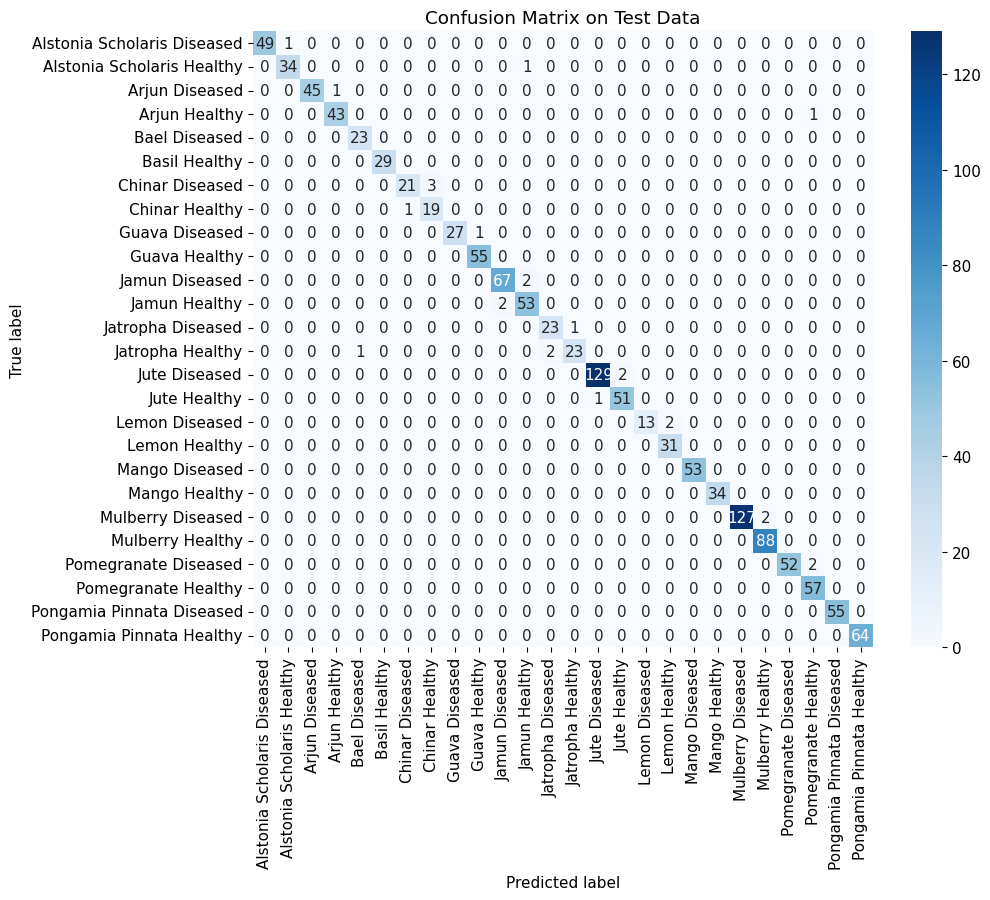

In [15]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


cm = confusion_matrix(y_truet, y_predt)

plt.rcParams.update({'font.size': 11})
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix on Test Data')
plt.show()

/opt/conda/lib/python3.10/site-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis 3 of a tensor of shape (16, 4, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


80/81 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step

/opt/conda/lib/python3.10/site-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis 3 of a tensor of shape (None, 4, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


81/81 ━━━━━━━━━━━━━━━━━━━━ 33s 240ms/step


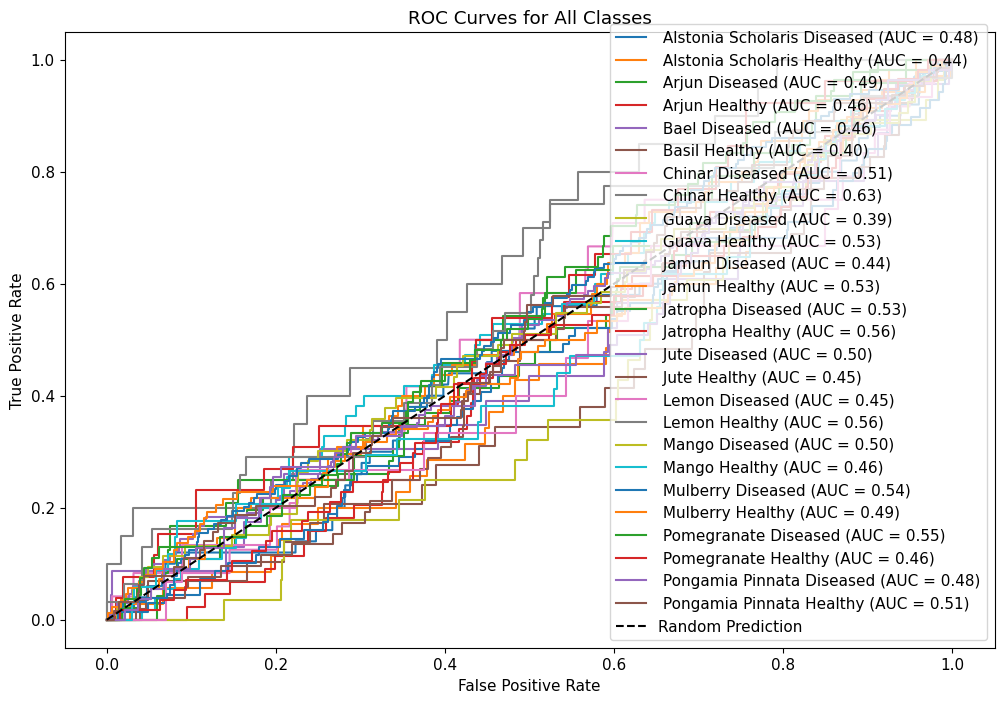

In [16]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import RocCurveDisplay
import matplotlib.pyplot as plt
import numpy as np


y_true_binarized = label_binarize(y_truet, classes=np.arange(num_classes))


y_score = model.predict(test_dataset)

fpr = dict()
tpr = dict()
roc_auc = dict()

plt.figure(figsize=(12, 8))

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_binarized[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

    plt.plot(fpr[i], tpr[i], label=f' {class_names[i]} (AUC = {roc_auc[i]:.2f})')


plt.plot([0, 1], [0, 1], 'k--', label='Random Prediction')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for All Classes')
plt.legend(loc='lower right')

plt.show()